In [ ]:
!pip install pandas matplotlib fpdf reportlab

from fpdf import FPDF
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.units import inch
from reportlab.lib import colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('font', family='NanumGothic')
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 한글 깨질 때 -> 코드 실행 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
# 컬럼명 수정 - train
train.rename(columns = {'본사정원수':'정원',
                        '본사휴가자수':'휴가',
                        '본사출장자수':'출장',
                        '본사시간외근무명령서승인건수':'야근',
                        '현본사소속재택근무자수':'재택'},
             inplace = True)  # inplace = True -> 바뀐 부분 적용

# 컬럼명 수정 - test
test.rename(columns = {'본사정원수':'정원',
                        '본사휴가자수':'휴가',
                        '본사출장자수':'출장',
                        '본사시간외근무명령서승인건수':'야근',
                        '현본사소속재택근무자수':'재택'},
             inplace = True)

In [ ]:
train = train.drop(['조식메뉴','중식메뉴','석식메뉴'], axis=1) # 메뉴 드랍

In [ ]:
# 년, 월, 일 구분
def date_split(df):
    df['일자'] = pd.to_datetime(df['일자'], format = "%Y-%m-%d")
    df['년'] = df['일자'].dt.year
    df['월'] = df['일자'].dt.month
    df['일'] = df['일자'].dt.day

    return df

# 함수호출
train = date_split(train)
train.head(2)

,일자,요일,정원,휴가,출장,야근,재택,중식계,석식계,년,월,일
0,2016-02-01,월,2601,50,150,238,0.0,1039.0,331.0,2016,2,1
1,2016-02-02,화,2601,50,173,319,0.0,867.0,560.0,2016,2,2


In [ ]:
# 날짜 전처리 - 일자 -> datetime / 요일 정보를 숫자로
def to_dateTime(df):
    df['일자'] = pd.to_datetime(df['일자'], format = "%Y-%m-%d") # 시계열 분석을 위해서는 데이터 타입이 object가 아닌 datetime형식이어야 함
    df['요일'] = pd.to_datetime(df['일자']).dt.weekday + 1       # 월:1,화:2,수:3,목:4,금:5
    return df

# 함수 호출
#to_dateTime(train)
train = to_dateTime(train)
train.head(2)

,일자,요일,정원,휴가,출장,야근,재택,중식계,석식계,년,월,일
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2016,2,1
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2016,2,2


In [ ]:
# 일자 임시 드랍
train_dateDrop = train.pop('일자')

# train['일자'] = train_dateDrop # 일자 컬럼 다시 추가

In [ ]:
# train 데이터 셋 탐색

train_corr = train.corr(method = 'pearson')
train_corr

,요일,정원,휴가,출장,야근,재택,중식계,석식계,년,월,일
요일,1.000000,-0.009671,0.155939,0.535655,-0.556452,-0.027724,-0.734273,-0.313240,-0.010811,0.002192,-0.006484
정원,-0.009671,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,-0.173852,0.764078,0.244705,-0.020737
휴가,0.155939,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,-0.316894,0.129875,0.193627,-0.009210
출장,0.535655,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,-0.188164,-0.109583,0.210877,0.144007
야근,-0.556452,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,0.571168,0.181749,0.018316,-0.093606
재택,-0.027724,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057534,0.571133,0.033586,-0.031583
중식계,-0.734273,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,0.508287,-0.078804,-0.154664,-0.097392
석식계,-0.313240,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.508287,1.000000,-0.194792,-0.127142,-0.185565
년,-0.010811,0.764078,0.129875,-0.109583,0.181749,0.571133,-0.078804,-0.194792,1.000000,-0.092612,-0.029843
월,0.002192,0.244705,0.193627,0.210877,0.018316,0.033586,-0.154664,-0.127142,-0.092612,1.000000,0.002120


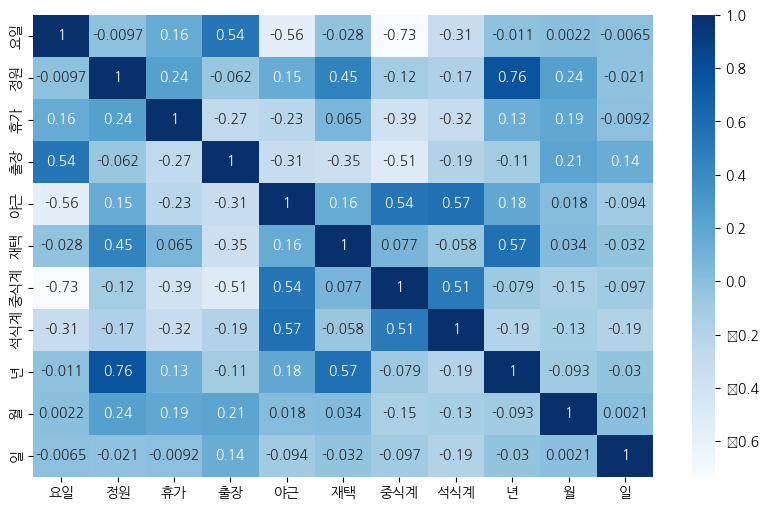

In [ ]:
# 기존 데이터 히트맵 표시
plt.rc('font', family='NanumGothic')
plt.figure(figsize=(10,6))
sns.heatmap(train_corr, annot=True, cmap='Blues') # annot=True -> 숫자정보 보이게 표시
plt.show()

In [ ]:
import statsmodels.formula.api as smf

- 위의 히트맵에서는 석식계와 야근이 가장 높은 상관계수를 나타냄   

In [ ]:
model_lm = smf.ols(formula = '석식계~야근', data=train)
result = model_lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    석식계   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     582.5
Date:                Wed, 26 Jun 2024   Prob (F-statistic):          2.84e-105
Time:                        05:50:47   Log-Likelihood:                -7419.0
No. Observations:                1205   AIC:                         1.484e+04
Df Residuals:                    1203   BIC:                         1.485e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    373.2781      4.928     75.747      0.0


## 날씨 데이터 (기온, 강수량, 풍속, 습도)  

In [ ]:
# 날씨 파일 불러오기
w1 = pd.read_csv('날씨1.csv', encoding='cp949')
w2 = pd.read_csv('날씨2.csv', encoding='cp949')
w3 = pd.read_csv('날씨3.csv', encoding='cp949')
w4 = pd.read_csv('날씨4.csv', encoding='cp949')
w5 = pd.read_csv('날씨5.csv', encoding='cp949')

In [ ]:
# 각각 행, 열 갯수 확인
print(w1.shape)
print(w2.shape)
print(w3.shape)
print(w4.shape)
print(w5.shape)

(8638, 7)
(8743, 7)
(8739, 7)
(8749, 7)
(8773, 7)


In [ ]:
# 일시 컬럼을 datetime으로 변경
w1['일시'] = pd.to_datetime(w1['일시'],format='%Y-%m-%d %H:%M')
w2['일시'] = pd.to_datetime(w2['일시'],format='%Y-%m-%d %H:%M')
w3['일시'] = pd.to_datetime(w3['일시'],format='%Y-%m-%d %H:%M')
w4['일시'] = pd.to_datetime(w4['일시'],format='%Y-%m-%d %H:%M')
w5['일시'] = pd.to_datetime(w5['일시'],format='%Y-%m-%d %H:%M')

In [ ]:
# 점심시간(12시)의 데이터만 추출
w1 = w1[w1['일시'].dt.hour == 12]
w2 = w2[w2['일시'].dt.hour == 12]
w3 = w3[w3['일시'].dt.hour == 12]
w4 = w4[w4['일시'].dt.hour == 12]
w5 = w5[w5['일시'].dt.hour == 12]

In [ ]:
# 행, 열 갯수 다시 확인
print(w1.shape)
print(w2.shape)
print(w3.shape)
print(w4.shape)
print(w5.shape)

(361, 7)
(364, 7)
(364, 7)
(365, 7)
(366, 7)


In [ ]:
# 12시 날씨 데이터 concat
w_all = pd.concat([w1,w2,w3,w4,w5])
w_all.head(2)

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,192,진주,2016-02-01 12:00:00,3.0,NaN,1.9,24.0
24,192,진주,2016-02-02 12:00:00,1.7,NaN,1.6,24.0


In [ ]:
# NaN값 확인
print(w_all.isna().any()) # 존재O

지점         False
지점명        False
일시         False
기온(°C)     False
강수량(mm)     True
풍속(m/s)     True
습도(%)      False
dtype: bool


In [ ]:
# NaN값 행 확인
w_all[w_all.isna( ).any(axis=1)]

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,192,진주,2016-02-01 12:00:00,3.0,NaN,1.9,24.0
24,192,진주,2016-02-02 12:00:00,1.7,NaN,1.6,24.0
48,192,진주,2016-02-03 12:00:00,3.2,NaN,1.5,31.0
72,192,진주,2016-02-04 12:00:00,3.7,NaN,0.7,30.0
96,192,진주,2016-02-05 12:00:00,6.3,NaN,1.0,17.0
...,...,...,...,...,...,...,...
8628,192,진주,2021-01-20 12:00:00,4.8,NaN,1.2,31.0
8652,192,진주,2021-01-21 12:00:00,9.1,NaN,0.4,52.0
8676,192,진주,2021-01-22 12:00:00,8.4,NaN,0.5,94.0
8724,192,진주,2021-01-24 12:00:00,11.1,NaN,2.4,59.0


In [ ]:
# 기록 안된 강수량컬럼 -> 0으로 채움
w_all['강수량(mm)'] = w_all['강수량(mm)'].fillna(value = 0)
w_all

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,192,진주,2016-02-01 12:00:00,3.0,0.0,1.9,24.0
24,192,진주,2016-02-02 12:00:00,1.7,0.0,1.6,24.0
48,192,진주,2016-02-03 12:00:00,3.2,0.0,1.5,31.0
72,192,진주,2016-02-04 12:00:00,3.7,0.0,0.7,30.0
96,192,진주,2016-02-05 12:00:00,6.3,0.0,1.0,17.0
...,...,...,...,...,...,...,...
8676,192,진주,2021-01-22 12:00:00,8.4,0.0,0.5,94.0
8700,192,진주,2021-01-23 12:00:00,10.1,0.3,0.6,91.0
8724,192,진주,2021-01-24 12:00:00,11.1,0.0,2.4,59.0
8748,192,진주,2021-01-25 12:00:00,11.3,0.0,2.6,54.0


In [ ]:
# NaN값 다시 확인
print(w_all.isna().any()) # 존재O

지점         False
지점명        False
일시         False
기온(°C)     False
강수량(mm)    False
풍속(m/s)     True
습도(%)      False
dtype: bool


In [ ]:
# NaN값 행 다시 확인 -> 풍속 컬럼 0 존재
w_all[w_all.isna( ).any(axis=1)]

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
6674,192,진주,2018-11-01 12:00:00,13.8,0.0,NaN,37.0
6794,192,진주,2018-11-06 12:00:00,17.6,0.0,NaN,52.0
1548,192,진주,2020-03-31 12:00:00,17.3,0.0,NaN,42.0
1884,192,진주,2020-04-14 12:00:00,19.6,0.0,NaN,14.0


In [ ]:
# 0으로 채움
w_all = w_all.fillna(0)
w_all

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,192,진주,2016-02-01 12:00:00,3.0,0.0,1.9,24.0
24,192,진주,2016-02-02 12:00:00,1.7,0.0,1.6,24.0
48,192,진주,2016-02-03 12:00:00,3.2,0.0,1.5,31.0
72,192,진주,2016-02-04 12:00:00,3.7,0.0,0.7,30.0
96,192,진주,2016-02-05 12:00:00,6.3,0.0,1.0,17.0
...,...,...,...,...,...,...,...
8676,192,진주,2021-01-22 12:00:00,8.4,0.0,0.5,94.0
8700,192,진주,2021-01-23 12:00:00,10.1,0.3,0.6,91.0
8724,192,진주,2021-01-24 12:00:00,11.1,0.0,2.4,59.0
8748,192,진주,2021-01-25 12:00:00,11.3,0.0,2.6,54.0


In [ ]:
w_all.isna().any() # NaN값 없음

지점         False
지점명        False
일시         False
기온(°C)     False
강수량(mm)    False
풍속(m/s)    False
습도(%)      False
dtype: bool

In [ ]:
w_all.head(2)

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,192,진주,2016-02-01 12:00:00,3.0,0.0,1.9,24.0
24,192,진주,2016-02-02 12:00:00,1.7,0.0,1.6,24.0


In [ ]:
# 필요없는 컬럼 drop
w_all = w_all.drop(['지점', '지점명'], axis = 1)

# train 데이터셋과 합치기 위해 컬럼명 수정
w_all.rename(columns = {'일시':'일자'}, inplace = True)  # inplace = True -> 바뀐 부분 적용

In [ ]:
 # 수정한 컬럼 다시 datetime 형식으로 변경
w_all['일자'] = pd.to_datetime(w_all['일자'],format='%Y-%m-%d %H:%M')
w_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1820 entries, 0 to 8772
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   일자       1820 non-null   datetime64[ns]
 1   기온(°C)   1820 non-null   float64       
 2   강수량(mm)  1820 non-null   float64       
 3   풍속(m/s)  1820 non-null   float64       
 4   습도(%)    1820 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 85.3 KB


In [ ]:
#w_all = w_all.reset_index()

In [ ]:
# 일자 컬럼에서 시간제외
w_all['일자'] = w_all['일자'].dt.date
w_all.head(2)

,일자,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,2016-02-01,3.0,0.0,1.9,24.0
24,2016-02-02,1.7,0.0,1.6,24.0


In [ ]:
# 시간 분리한 일자 컬럼 다시 datetime으로 변경
w_all['일자'] = pd.to_datetime(w_all['일자'], format = "%Y-%m-%d")
w_all.head(2)

,일자,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,2016-02-01,3.0,0.0,1.9,24.0
24,2016-02-02,1.7,0.0,1.6,24.0


In [ ]:
#w_all = w_all.set_index('일자',drop=True)
#w_all = w_all.reset_index()

In [ ]:
w_all.info() # datetime인지확인

<class 'pandas.core.frame.DataFrame'>
Index: 1820 entries, 0 to 8772
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   일자       1820 non-null   datetime64[ns]
 1   기온(°C)   1820 non-null   float64       
 2   강수량(mm)  1820 non-null   float64       
 3   풍속(m/s)  1820 non-null   float64       
 4   습도(%)    1820 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 149.9 KB


## 폭염 컬럼 생성   

In [ ]:
# 기온컬럼 이용 -> 폭염인 경우 1 / 폭염 아닌 경우 0으로 분류

hw = 33         # 폭염 기준 온도값 초기화
w_all['폭염'] = w_all['기온(°C)'].apply(lambda x: 1 if x >= hw else 0) # 33도 이상이면 1 아니면 0
w_all.head(2)

,일자,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염
0,2016-02-01,3.0,0.0,1.9,24.0,0
24,2016-02-02,1.7,0.0,1.6,24.0,0


In [ ]:
w_all[w_all['폭염']==1].head(2) # 폭염 1인 행들 2개 출력

,일자,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염
4341,2016-07-31,33.1,0.0,1.8,46.0,1
4533,2016-08-08,33.5,0.0,1.5,46.0,1


## 불쾌지수와 체감온도 컬럼 생성  

In [ ]:
# 불쾌지수, 체감온도 계산
# 불쾌지수 = 1.8x기온 – 0.55x(1–습도)x(1.8x기온–26)+32
# 체감온도 = 13.12 + 0.6215*기온 - 11.37*풍속^0.16 + 0.3965*풍속^0.16*기온

w_all['불쾌지수'] = 1.8 * w_all['기온(°C)'] - 0.55 * (1 - w_all['습도(%)'] / 100) * (1.8 * w_all['기온(°C)'] - 26) + 32
w_all['체감온도'] = 13.12 + 0.6215 * w_all['기온(°C)']- 11.37 * w_all['풍속(m/s)']**0.16 + 0.3965 * w_all['기온(°C)'] * w_all['풍속(m/s)']**0.16

In [ ]:
w_all.head(2)

,일자,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염,불쾌지수,체감온도
0,2016-02-01,3.0,0.0,1.9,24.0,0,46.01080,3.702926
24,2016-02-02,1.7,0.0,1.6,24.0,0,44.64892,2.645242


In [ ]:
# train 데이터 다시 불러오기
train = pd.read_csv('train.csv')

# 컬럼명 수정 - train
train_t = train.rename(columns = {'본사정원수':'정원',
                        '본사휴가자수':'휴가',
                        '본사출장자수':'출장',
                        '본사시간외근무명령서승인건수':'야근',
                        '현본사소속재택근무자수':'재택'},
             inplace = True)  # inplace = True -> 바뀐 부분 적용

# 날짜 -> 년 월 일로 분리
train_t = date_split(train)

# 요일 -> 숫자로 변경
train_t['요일'] = pd.to_datetime(train_t['일자']).dt.weekday + 1       # 월:1,화:2,수:3,목:4,금:5

train_t.head()

,일자,요일,정원,휴가,출장,야근,재택,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,년,월,일
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016,2,2
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2016,2,3
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2016,2,4
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2016,2,5


In [ ]:
train_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      1205 non-null   datetime64[ns]
 1   요일      1205 non-null   int32         
 2   정원      1205 non-null   int64         
 3   휴가      1205 non-null   int64         
 4   출장      1205 non-null   int64         
 5   야근      1205 non-null   int64         
 6   재택      1205 non-null   float64       
 7   조식메뉴    1205 non-null   object        
 8   중식메뉴    1205 non-null   object        
 9   석식메뉴    1205 non-null   object        
 10  중식계     1205 non-null   float64       
 11  석식계     1205 non-null   float64       
 12  년       1205 non-null   int32         
 13  월       1205 non-null   int32         
 14  일       1205 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(4), int64(4), object(3)
memory usage: 122.5+ KB


In [ ]:
w_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1820 entries, 0 to 8772
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   일자       1820 non-null   datetime64[ns]
 1   기온(°C)   1820 non-null   float64       
 2   강수량(mm)  1820 non-null   float64       
 3   풍속(m/s)  1820 non-null   float64       
 4   습도(%)    1820 non-null   float64       
 5   폭염       1820 non-null   int64         
 6   불쾌지수     1820 non-null   float64       
 7   체감온도     1820 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 192.5 KB


In [ ]:
# 날씨 데이터와 merge
train_t = train_t.merge(w_all,on = '일자', how='left').fillna(0)  # train 데이터셋을 기준으로 병합
train_t.head(3)

,일자,요일,정원,휴가,출장,야근,재택,조식메뉴,중식메뉴,석식메뉴,...,년,월,일,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염,불쾌지수,체감온도
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,2016,2,1,3.0,0.0,1.9,24.0,0.0,46.01080,3.702926
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,2016,2,2,1.7,0.0,1.6,24.0,0.0,44.64892,2.645242
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,2016,2,3,3.2,0.0,1.5,31.0,0.0,45.44108,4.330567


In [ ]:
# 폭염 컬럼 int로 변환
train_t['폭염'] = train_t['폭염'].astype(int)
train_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   일자       1205 non-null   datetime64[ns]
 1   요일       1205 non-null   int32         
 2   정원       1205 non-null   int64         
 3   휴가       1205 non-null   int64         
 4   출장       1205 non-null   int64         
 5   야근       1205 non-null   int64         
 6   재택       1205 non-null   float64       
 7   조식메뉴     1205 non-null   object        
 8   중식메뉴     1205 non-null   object        
 9   석식메뉴     1205 non-null   object        
 10  중식계      1205 non-null   float64       
 11  석식계      1205 non-null   float64       
 12  년        1205 non-null   int32         
 13  월        1205 non-null   int32         
 14  일        1205 non-null   int32         
 15  기온(°C)   1205 non-null   float64       
 16  강수량(mm)  1205 non-null   float64       
 17  풍속(m/s)  1205 non-null   float64 

In [ ]:
# NaN값 확인
train_t.isna().any() # NaN값 없음

일자         False
요일         False
정원         False
휴가         False
출장         False
야근         False
재택         False
조식메뉴       False
중식메뉴       False
석식메뉴       False
중식계        False
석식계        False
년          False
월          False
일          False
기온(°C)     False
강수량(mm)    False
풍속(m/s)    False
습도(%)      False
폭염         False
불쾌지수       False
체감온도       False
dtype: bool

### 계절분리  

In [ ]:
# 파생변수 -> 계절(1234)
def get_season(s):
  if s in [3, 4, 5]: # 봄
      return 1
  elif s in [6, 7, 8]: # 여름
      return 2
  elif s in [9, 10, 11]: # 가을
      return 3
  else:                  # 겨울
      return 4

  return s

# 계절컬럼 생성 - 함수적용
train_t['계절'] = train_t['월'].apply(get_season)

In [ ]:
#train.describe()

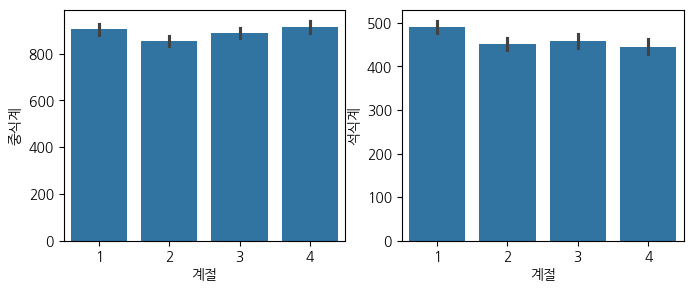

In [ ]:
#plt.figure(figsize=(5,5))
#sns.barplot(train_w_all, x = '계절', y = '중식계')
#plt.title('계절별 중식계 평균 수')

fig, ax = plt.subplots(1,2,figsize=(8,3))
sns.barplot(x=train_t['계절'], y=train_t['중식계'],ax=ax[0])
sns.barplot(x=train_t['계절'], y=train_t['석식계'], ax=ax[1])
plt.show()

# 여름에 식사인원이 가장 적음

In [ ]:
# 확인용
# train_w_all.loc[300:350]

### 강수량으로 강수량정도 계산

In [ ]:
# 파생변수 -> 강수량 -> 없음or약한비(0)/보통비(1)/강한비(2)/매우강한비(3)로 나누어 표현 (기상청 강수표현 참고)
def get_rain(rain):
  if rain >= 30:
    return 3
  elif rain >= 15:
    return 2
  elif rain >= 3:
    return 1
  else:
    return 0

# 강수량정도 컬럼 - 강수량컬럼에 get_rain함수 적용
train_t['강수량정도'] = train_t['강수량(mm)'].apply(get_rain)

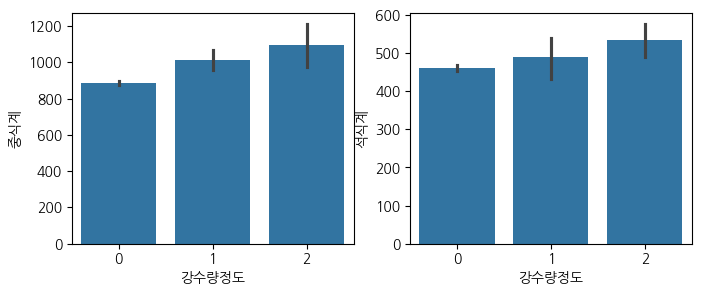

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
sns.barplot(train_t, x='강수량정도', y='중식계',ax=ax[0])
sns.barplot(train_t, x='강수량정도', y='석식계',ax=ax[1])
plt.show()

# 비가 많이 올수록 식당이용자 수가 높아짐 (매우강한비는 분류되지않음)

In [ ]:
train_t[train_t['강수량정도']==3] # 매우강한비(3)는 없음..

,일자,요일,정원,휴가,출장,야근,재택,조식메뉴,중식메뉴,석식메뉴,...,일,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염,불쾌지수,체감온도,계절,강수량정도


## 미세먼지 데이터  

In [ ]:
# 미세먼지 데이터셋 불러오기 (경상남도 진주시 상대동(측정소))
m1 = pd.read_csv('미세먼지_160201_170126.csv', encoding='cp949')
m2 = pd.read_csv('미세먼지_170127_180126.csv', encoding='cp949')
m3 = pd.read_csv('미세먼지_180127_190126.csv', encoding='cp949')
m4 = pd.read_csv('미세먼지_190127_200126.csv', encoding='cp949')
m5 = pd.read_csv('미세먼지_200127_210126.csv', encoding='cp949')

In [ ]:
# 년도별 미세먼지 데이터 concat
m_all = pd.concat([m1, m2, m3, m4, m5])
m_all.head(3)

,일자,PM-10
0,2016-02-01,36.0
1,2016-02-02,34.0
2,2016-02-03,54.0


In [ ]:
# 행, 열 갯수 확인
print(m_all.shape)
print('\n')

# NaN값 여부
print(m1.isna().any())

(1822, 2)


일자       False
PM-10     True
dtype: bool


In [ ]:
# NaN값 있는 행 출력
# m_all[m_all.isna( ).any(axis=1)]

In [ ]:
# NaN 값을 월평균 미세먼지농도 값으로 대체하는 함수

def nan_to_month_mean(df, date_col, value_col):

    df[date_col] = pd.to_datetime(df[date_col]) # 일자를 datetime 형식으로 변환
    df['month'] = df[date_col].dt.month  # 'month' 열 추가

    month_means = df.groupby('month')[value_col].transform('mean') # 월별 평균값 계산
    #print(month_means.iloc[90:100]) #확인용print
    df[value_col] = df[value_col].fillna(month_means)  # 결측값을 월평균값으로 대체

    df.drop(columns=['month'], inplace=True)  # 'month' 열 삭제

    return df

In [ ]:
# 함수호출
m_all = nan_to_month_mean(m_all, '일자', 'PM-10')
m_all.head(3)

,일자,PM-10
0,2016-02-01,36.0
1,2016-02-02,34.0
2,2016-02-03,54.0


In [ ]:
# NaN값 있는 행 출력
#m_all[m_all.isna( ).any(axis=1)]

In [ ]:
# 컬럼명 변경
m_all.rename(columns = {'PM-10':'미세먼지'}, inplace = True)
m_all.head(2)

,일자,미세먼지
0,2016-02-01,36.0
1,2016-02-02,34.0


In [ ]:
# train_t 데이터셋과 merge
train_t = train_t.merge(m_all, how='left')  # train_t데이터셋을 기준으로 병합
train_t

,일자,요일,정원,휴가,출장,야근,재택,조식메뉴,중식메뉴,석식메뉴,...,기온(°C),강수량(mm),풍속(m/s),습도(%),폭염,불쾌지수,체감온도,계절,강수량정도,미세먼지
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,3.0,0.0,1.9,24.0,0,46.01080,3.702926,4,0,36.0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,1.7,0.0,1.6,24.0,0,44.64892,2.645242,4,0,34.0
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,3.2,0.0,1.5,31.0,0,45.44108,4.330567,4,0,54.0
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,3.7,0.0,0.7,30.0,0,46.10590,6.065918,4,0,78.0
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,6.3,0.0,1.0,17.0,0,50.03229,8.163400,4,0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,3,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,...,4.8,0.0,1.2,31.0,0,47.22812,6.356172,4,0,34.0
1201,2021-01-21,4,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,...,9.1,0.0,0.4,52.0,0,50.91968,12.072254,4,0,30.0
1202,2021-01-22,5,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,...,8.4,0.0,0.5,94.0,0,47.47904,11.145135,4,0,32.0
1203,2021-01-25,1,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,...,11.3,0.0,2.6,54.0,0,53.77198,12.115334,4,0,21.0


In [ ]:
#train_t.isna().any()

In [ ]:
train_t.columns

Index(['일자', '요일', '정원', '휴가', '출장', '야근', '재택', '조식메뉴', '중식메뉴', '석식메뉴', '중식계',
       '석식계', '년', '월', '일', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '폭염',
       '불쾌지수', '체감온도', '계절', '강수량정도', '미세먼지'],
      dtype='object')

In [ ]:
#train_t.shape

In [ ]:
# 히트맵으로 나타낼 변수 선택
heat_cols = ['휴가','출장','야근','기온(°C)','강수량(mm)','풍속(m/s)','습도(%)','불쾌지수','체감온도','미세먼지', '강수량정도','폭염','계절','중식계','석식계']

# 상관관계
train_t[heat_cols].corr()
# sns.heatmap(train_w_m_all[heat_cols].corr(), annot = True)

,휴가,출장,야근,기온(°C),강수량(mm),풍속(m/s),습도(%),불쾌지수,체감온도,미세먼지,강수량정도,폭염,계절,중식계,석식계
휴가,1.000000,-0.273318,-0.230789,0.203865,-0.036184,-0.040524,0.108719,2.190002e-01,0.206519,-0.129242,-0.034608,0.214151,0.016877,-0.391975,-3.168935e-01
출장,-0.273318,1.000000,-0.308757,0.138835,-0.007514,0.005544,0.005423,1.198753e-01,0.137132,0.065814,-0.022500,-0.042672,-0.111882,-0.512680,-1.881644e-01
야근,-0.230789,-0.308757,1.000000,-0.052752,0.013201,0.029051,0.007062,-5.213295e-02,-0.056028,-0.045945,0.019700,-0.039753,0.034146,0.535611,5.711684e-01
기온(°C),0.203865,0.138835,-0.052752,1.000000,-0.024628,-0.006451,0.336640,9.852959e-01,0.996755,-0.045339,-0.052566,0.233975,-0.532480,-0.118348,4.400898e-03
강수량(mm),-0.036184,-0.007514,0.013201,-0.024628,1.000000,-0.104779,0.333736,-2.188552e-02,-0.014862,-0.124525,0.869701,-0.022098,-0.014182,0.096270,3.675262e-02
풍속(m/s),-0.040524,0.005544,0.029051,-0.006451,-0.104779,1.000000,-0.320018,-1.717763e-04,-0.063289,-0.078410,-0.115891,0.011258,-0.106801,0.030513,1.019201e-01
습도(%),0.108719,0.005423,0.007062,0.336640,0.333736,-0.320018,1.000000,3.665210e-01,0.359131,-0.259650,0.341182,-0.015805,-0.102298,0.026337,-5.943666e-02
불쾌지수,0.219000,0.119875,-0.052133,0.985296,-0.021886,-0.000172,0.366521,1.000000e+00,0.980660,-0.081475,-0.057726,0.218882,-0.494764,-0.115287,-2.286896e-07
체감온도,0.206519,0.137132,-0.056028,0.996755,-0.014862,-0.063289,0.359131,9.806602e-01,1.000000,-0.039018,-0.039363,0.232937,-0.523354,-0.120459,-2.506790e-03
미세먼지,-0.129242,0.065814,-0.045945,-0.045339,-0.124525,-0.078410,-0.259650,-8.147476e-02,-0.039018,1.000000,-0.132295,0.029939,-0.048886,-0.024802,5.267120e-02


<Axes: >

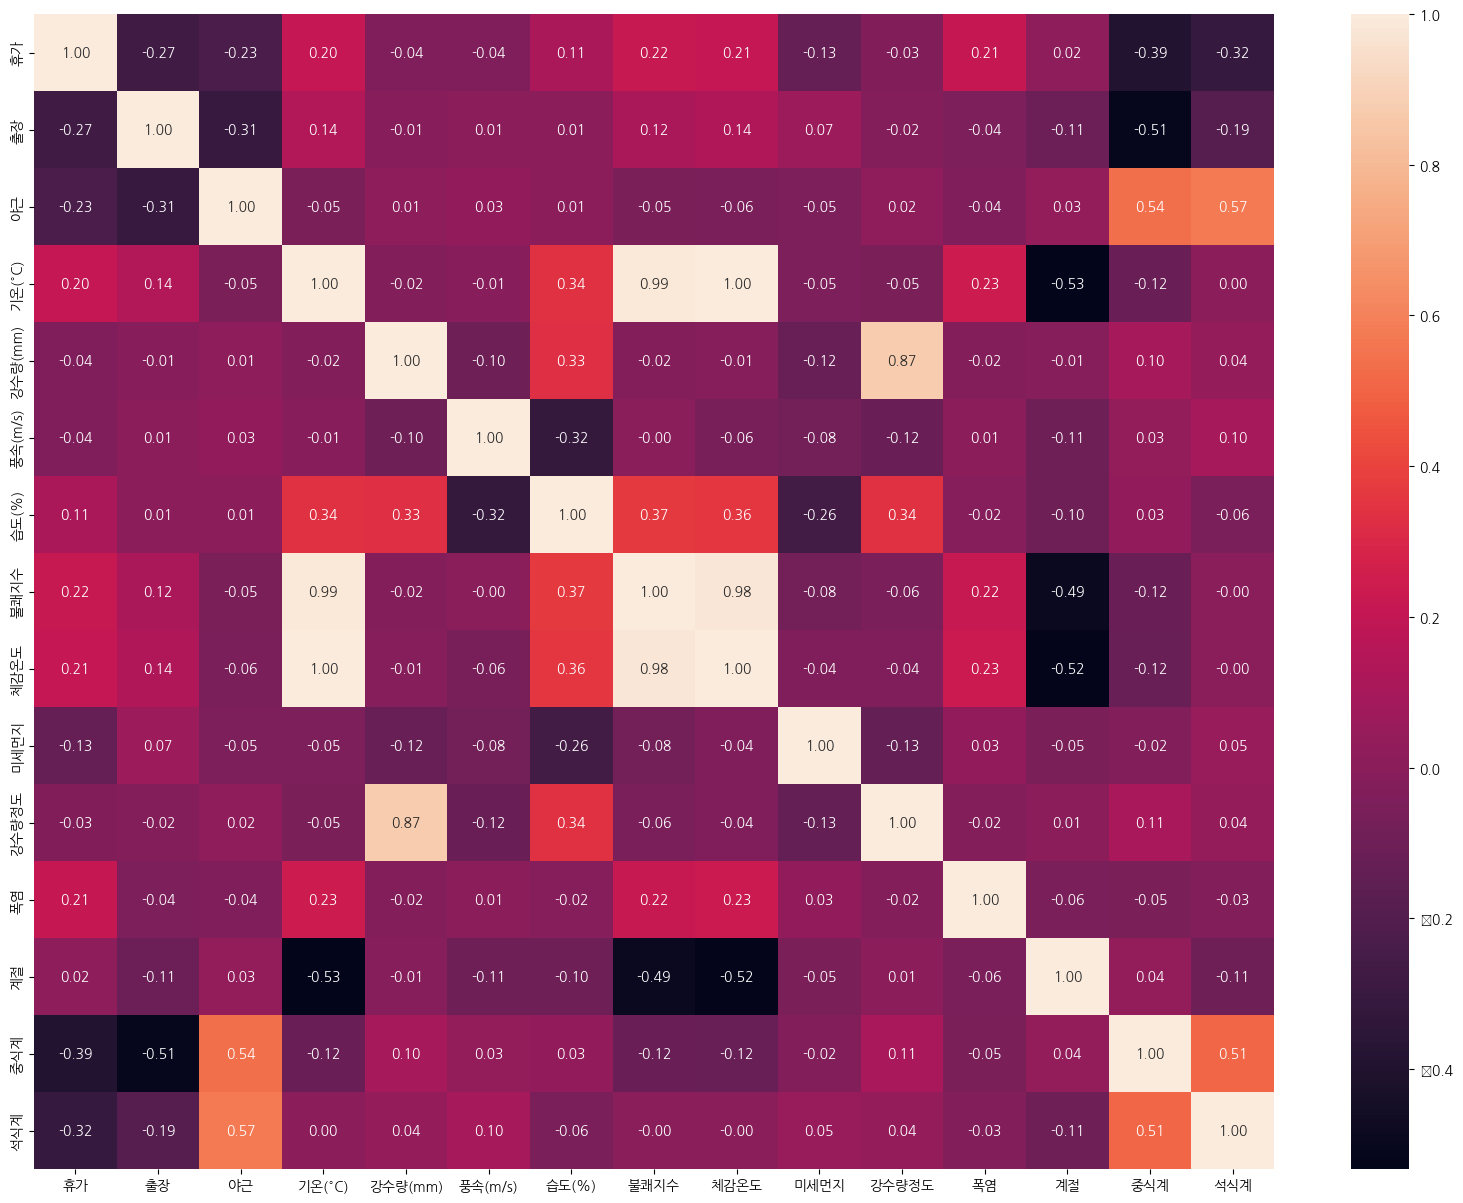

In [ ]:
plt.figure(figsize = (20,15))
sns.heatmap(train_t[heat_cols].corr(), fmt = '.2f', annot = True)

In [ ]:
# 실제식수인원
# 실제식수인원 = 휴가 - 출장 - 재택


## 강수형태 데이터  
- 점심강수여부 컬럼 생성  

In [ ]:
# 강수형태 데이터 불러오기
r1 = pd.read_csv('충무공동_강수형태_201602_201701.csv')
r2 = pd.read_csv('충무공동_강수형태_201702_201801.csv')
r3 = pd.read_csv('충무공동_강수형태_201802_201901.csv')
r4 = pd.read_csv('충무공동_강수형태_201902_202001.csv')
r5 = pd.read_csv('충무공동_강수형태_202002_202101.csv')

In [ ]:
# r_list 생성
r_list = [r1, r2, r3, r4, r5]

# 각 DataFrame의 열 이름을 변경
for i in r_list:
    i.columns = ['일자', '시간', 'rain']

In [ ]:
# 년도별 미세먼지 데이터 concat
r_all = pd.concat([r1, r2, r3, r4, r5])
r_all.head()

,일자,시간,rain
0,1,0.0,0.0
1,1,100.0,0.0
2,1,200.0,0.0
3,1,300.0,0.0
4,1,400.0,0.0


In [ ]:
# 10시 ~14시(1000 ~ 1400기간)데이터만 추출
rain1 = r_all[r_all['시간'] >= 1000]  # 1000(10시)이상 데이터 추출 후 저장
rain2 = rain1[rain1['시간'] <= 1400]  # 10시 이상 데이터 중 14시 이하의 데이터 추출 후 저장
rain_use = rain2.copy()                # 복사본으로 저장
rain_use.head(4)

,일자,시간,rain
10,1,1000.0,0.0
11,1,1100.0,0.0
12,1,1200.0,0.0
13,1,1300.0,0.0


In [ ]:
# 인덱스 초기화
rain_use = rain_use.reset_index(drop=True)
rain_use.head(5)

,일자,시간,rain
0,1,1000.0,0.0
1,1,1100.0,0.0
2,1,1200.0,0.0
3,1,1300.0,0.0
4,1,1400.0,0.0


In [ ]:
rain_use.shape

(9110, 3)

In [ ]:
# 결측값 출력
print(rain_use.isna().any())

일자      False
시간      False
rain    False
dtype: bool


In [ ]:
rain_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9110 entries, 0 to 9109
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      9110 non-null   object 
 1   시간      9110 non-null   float64
 2   rain    9110 non-null   float64
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


In [ ]:
from datetime import datetime, timedelta, date

In [ ]:
start_date = pd.to_datetime('2016-02-01')
end_date = pd.to_datetime('2021-01-26')
n = 5 # 10, 11, 12, 13, 14 -> 다섯번 반복(같은 날짜 다섯번 반복 )

start_date

Timestamp('2016-02-01 00:00:00')

In [ ]:
# 일만 표시되어 있는 일자 컬럼 -> 년-월-일로 변경
def date_list(start, end, n=1):
  d_list = []
  while start.strftime('%Y%m%d') != (end + timedelta(days=1)).strftime('%Y%m%d'):
    for i in range(n):
      d_list.append(start.strftime('%y-%d-%m'))
    start += timedelta(days=1)

  return d_list